In [3]:
import dgl
import torch
import pandas as pd
# 读取共现关系矩阵和TF-IDF关系矩阵
df_comatrix_normalized = pd.read_csv(r'C:\Users\86198\Desktop\GCN_Link_Prediction\data\comatrix_normalized.csv', index_col=0)
pd_data = pd.read_csv(r'C:\Users\86198\Desktop\GCN_Link_Prediction\data\webofsci_tf-idf_features.csv', index_col=0)
# 假设df_comatrix的索引和列都是词汇，pd_data的索引是文档ID，列是词汇
words = df_comatrix_normalized.columns
docs = pd_data.index
# 创建词汇和文档的节点类型
word_ids = torch.tensor(range(len(words)))
num_words = len(word_ids)
word_features = torch.eye(num_words)
doc_ids = torch.tensor(range(len(docs)))
num_docs = len(doc_ids)
doc_features = torch.eye(num_docs)
# 创建词汇与词汇之间的边
word_word_edges = torch.tensor([df_comatrix_normalized.stack().index.codes[0].tolist(), df_comatrix_normalized.stack().index.codes[1].tolist()])
# 创建文档与词汇之间的边
doc_word_edges = torch.tensor([pd_data.stack().index.codes[0].tolist(), pd_data.stack().index.codes[1].tolist()])

# 提取词与词之间的权重
word_word_weights = torch.tensor(df_comatrix_normalized.stack().values.tolist())
# 提取文档与词之间的TF-IDF权重
doc_word_weights = torch.tensor(pd_data.stack().values.tolist())
# 构建异构图
graph_data = {
    ('word', 'co-occurrence', 'word'): (word_word_edges[0], word_word_edges[1]),
    ('doc', 'tf-idf', 'word'): (doc_word_edges[0], doc_word_edges[1])
}
g = dgl.heterograph(graph_data)
# 设置节点特征
g.nodes['word'].data['feat'] = word_features
g.nodes['doc'].data['feat'] = doc_features

# 设置边特征
g.edges['co-occurrence'].data['weight'] = word_word_weights
g.edges['tf-idf'].data['weight'] = doc_word_weights
# 检查图的信息
print(g)

Graph(num_nodes={'doc': 2840, 'word': 3911},
      num_edges={('doc', 'tf-idf', 'word'): 11107240, ('word', 'co-occurrence', 'word'): 15295921},
      metagraph=[('doc', 'word', 'tf-idf'), ('word', 'word', 'co-occurrence')])


In [ ]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import GraphConv

# 假设您已经有了一个DGL异构图hetero_graph
hetero_graph = ...

# 定义一个图神经网络模型
class HeteroGraphModel(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super(HeteroGraphModel, self).__init__()
        self.conv1 = GraphConv(in_size, hidden_size)
        self.conv2 = GraphConv(hidden_size, out_size)

    def forward(self, g, features):
        h = self.conv1(g, features)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# 实例化模型
model = HeteroGraphModel(in_size, hidden_size, out_size)

# 定义损失函数和优化器
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 准备训练集和测试集
train_data = ...
test_data = ...

# 模型训练
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    # 前向传播
    logits = model(hetero_graph, train_data)
    # 计算损失
    loss = criterion(logits, labels)
    # 反向传播和优化
    loss.backward()
    optimizer.step()

# 模型评估
model.eval()
with torch.no_grad():
    # 前向传播
    test_logits = model(hetero_graph, test_data)
    # 计算测试集上的损失
    test_loss = criterion(test_logits, test_labels)
    # 计算其他性能指标，例如AUC
    ...

print('Test Loss:', test_loss.item())


In [2]:
# 训练整个模型
# ? 导入模块
import numpy as np
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh  # .eigen.arpack
import sys
import re
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import dgl
import torch
import tqdm
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import dgl.nn as dglnn
import dgl.function as fn
from dgl.nn.pytorch import GraphConv, SAGEConv, HeteroGraphConv
import argparse
import torch.optim as optim
from dgl.dataloading import MultiLayerFullNeighborSampler,DataLoader,as_edge_prediction_sampler
from dgl.dataloading.negative_sampler import Uniform
import itertools
import os
from dgl import save_graphs, load_graphs
from dgl.utils import expand_as_pair
from collections import defaultdict
from dgl.data.utils import makedirs, save_info, load_info
from sklearn.metrics import roc_auc_score
import gc
gc.collect()
from dgl.nn import GraphConv,SAGEConv
from utils import *

# 定义文件路径
train_path = '/home/lym/lab/project_work/GCN_Link_Prediction/data/webofsci_vocabulary_train.txt'
test_path = '/home/lym/lab/project_work/GCN_Link_Prediction/data/webofsci_vocabulary_test.txt'

# 调用函数并将结果存储在列表中
new_words = find_new_words(train_path, test_path)

# 打印独有的词
print(f"Test词表中独有的词: {new_words}")
print(len(new_words))

Test词表中独有的词: ['railway', 'fgcr', 'sigma', 'convection', 'graduate', 'dstd', 'ssnc', 'risky', 'informed', 'farm', 'perovskite', 'cage', 'scuc', 'budget', 'cncf', 'surrogate', 'gras', 'dmso', 'tailored', 'heartbeat', 'begcn', 'ufzs', 'zro2', 'bedrock', 'creatinine', 'college', 'gtfn', 'gshuttle', 'cas9', 'encrypted', 'bertgcn', 'copi', 'anatomic', 'sptv', 'mgfe', 'multiedge', 'pvdf', 'energetic', 'helix', 'benzimidazole', 'blazepose', 'agcfn', 'seawater']
43


In [8]:
import pandas as pd
import numpy as np

# 假设 comatrix 是您的共现矩阵，行和列的标签都是词的字符串
comatix_test_label = pd.read_csv(r'/home/lym/lab/project_work/GCN_Link_Prediction/data/comatrix_test_label.csv', index_col=0)

# 将DataFrame转换为长格式，并保留原始的行和列标签
stacked_comatrix = comatix_test_label.stack().reset_index()

# 重命名列以更清晰地表示数据
stacked_comatrix.columns = ['row_word', 'col_word', 'weight']

# 过滤出上三角部分的数据（不包括对角线）
upper_tri = stacked_comatrix[stacked_comatrix['row_word'] < stacked_comatrix['col_word']]

print(upper_tri)


         row_word       col_word  weight
11           opmd           path       0
13           opmd     superpixel       0
19           opmd  photocatalyst       0
29           opmd  petrophysical       0
30           opmd        sensing       0
...           ...            ...     ...
11095555  circrna       validity       0
11095556  circrna       properly       0
11095557  circrna        general       0
11095558  circrna       training       0
11095559  circrna       occluded       0

[5546115 rows x 3 columns]


In [9]:
import pandas as pd

# 加载 wordid_decode_map.csv 文件
wordid_decode_df = pd.read_csv('./data/wordid_decode_map.csv')

# 创建从词名称到索引的映射字典
word_to_index = dict(zip(wordid_decode_df['Original Word'], wordid_decode_df['Encoded ID']))

# 假设 upper_tri 是您已经有的DataFrame，其中包含词的名称
# 替换 'row_word' 和 'col_word' 列中的词名称为索引
upper_tri.loc[:, 'row_word'] = upper_tri['row_word'].map(word_to_index)
upper_tri.loc[:, 'col_word'] = upper_tri['col_word'].map(word_to_index)

# 现在 upper_tri 的 'row_word' 和 'col_word' 列包含了词的索引
print(upper_tri)


         row_word col_word  weight
11           5057     1837       0
13           5057     1420       0
19           5057     4689       0
29           5057     3797       0
30           5057     1875       0
...           ...      ...     ...
11095555     1977      981       0
11095556     1977     1027       0
11095557     1977     2208       0
11095558     1977     3839       0
11095559     1977     3247       0

[5546115 rows x 3 columns]


In [1]:
import dgl
import dgl.nn as dglnn
import dgl.function as fn
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

n_users = 1000
n_items = 500
n_follows = 3000
n_clicks = 5000
n_dislikes = 500
n_hetero_features = 10
n_user_classes = 5
n_max_clicks = 10

follow_src = np.random.randint(0, n_users, n_follows)
follow_dst = np.random.randint(0, n_users, n_follows)
click_src = np.random.randint(0, n_users, n_clicks)
click_dst = np.random.randint(0, n_items, n_clicks)
dislike_src = np.random.randint(0, n_users, n_dislikes)
dislike_dst = np.random.randint(0, n_items, n_dislikes)

hetero_graph = dgl.heterograph({
    ('user', 'follow', 'user'): (follow_src, follow_dst),
    ('user', 'followed-by', 'user'): (follow_dst, follow_src),
    ('user', 'click', 'item'): (click_src, click_dst),
    ('item', 'clicked-by', 'user'): (click_dst, click_src),
    ('user', 'dislike', 'item'): (dislike_src, dislike_dst),
    ('item', 'disliked-by', 'user'): (dislike_dst, dislike_src)})

hetero_graph.nodes['user'].data['feature'] = torch.randn(n_users, n_hetero_features)
hetero_graph.nodes['item'].data['feature'] = torch.randn(n_items, n_hetero_features)
hetero_graph.nodes['user'].data['label'] = torch.randint(0, n_user_classes, (n_users,))
hetero_graph.edges['click'].data['label'] = torch.randint(1, n_max_clicks, (n_clicks,)).float()
# randomly generate training masks on user nodes and click edges
hetero_graph.nodes['user'].data['train_mask'] = torch.zeros(n_users, dtype=torch.bool).bernoulli(0.6)
hetero_graph.edges['click'].data['train_mask'] = torch.zeros(n_clicks, dtype=torch.bool).bernoulli(0.6)

class HeteroDotProductPredictor(nn.Module):
    def forward(self, graph, h, etype):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'), etype=etype)
            return graph.edges[etype].data['score']

def construct_negative_graph(graph, k, etype):
    utype, _, vtype = etype
    src, dst = graph.edges(etype=etype)
    neg_src = src.repeat_interleave(k)
    neg_dst = torch.randint(0, graph.num_nodes(vtype), (len(src) * k,))
    return dgl.heterograph(
        {etype: (neg_src, neg_dst)},
        num_nodes_dict={ntype: graph.num_nodes(ntype) for ntype in graph.ntypes})


class RGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super().__init__()
        self.conv1 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(in_feats, hid_feats)
            for rel in rel_names}, aggregate='sum')
        self.conv2 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(hid_feats, out_feats)
            for rel in rel_names}, aggregate='sum')

    def forward(self, graph, inputs):
        h = self.conv1(graph, inputs)
        h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv2(graph, h)
        return h

class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names):
        super().__init__()
        self.sage = RGCN(in_features, hidden_features, out_features, rel_names)
        self.pred = HeteroDotProductPredictor()
    def forward(self, g, neg_g, x, etype):
        h = self.sage(g, x)
        return self.pred(g, h, etype), self.pred(neg_g, h, etype)

def compute_loss(pos_score, neg_score):
    n_edges = pos_score.shape[0]
    return (1 - pos_score.unsqueeze(1) + neg_score.view(n_edges, -1)).clamp(min=0).mean()

k = 5
model = Model(10, 20, 5, hetero_graph.etypes)
user_feats = hetero_graph.nodes['user'].data['feature']
item_feats = hetero_graph.nodes['item'].data['feature']
node_features = {'user': user_feats, 'item': item_feats}
opt = torch.optim.Adam(model.parameters())
for epoch in range(100):
    negative_graph = construct_negative_graph(hetero_graph, k, ('user', 'click', 'item'))
    pos_score, neg_score = model(hetero_graph, negative_graph, node_features, ('user', 'click', 'item'))
    loss = compute_loss(pos_score, neg_score)
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())


/home/lym/anaconda3/envs/dgl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.371546745300293
1.3677899837493896
1.3327302932739258
1.3105076551437378
1.287018895149231
1.2690627574920654
1.246730923652649
1.2327066659927368
1.2123388051986694
1.208645224571228


In [3]:
import numpy as np
from scipy.stats import shapiro

# 您提供的数据
data = [
    4.206487, 4.0437202, -4.492837, 6.3180633, 2.7669873, -4.6339445,
    5.3221483, 4.297885, 3.8400822, 3.2372594, -3.335034, -4.3169374,
    2.8835936, -6.075342, 1.2202237, -5.984989
]

# 将数据转换为NumPy数组
data = np.array(data)

# 执行Shapiro-Wilk检验
stat, p = shapiro(data)

print('统计量=%.3f, p值=%.3f' % (stat, p))

# 解释结果
if p > 0.05:
    print('样本数据看起来是高斯分布（正态分布）。')
else:
    print('样本数据看起来不是高斯分布（正态分布）。')


统计量=0.845, p值=0.011
样本数据看起来不是高斯分布（正态分布）。


方差: [0.00129888 0.00138546 0.00131343 0.00144238 0.00151519 0.00133409
 0.00131815 0.00144599 0.00137464 0.00130904 0.00143766 0.00137112
 0.00134796 0.0014404  0.00120032 0.0014591 ]
相似度: [[1.         0.99968342 0.99975318 ... 0.99978676 0.99978917 0.99977005]
 [0.99968342 1.         0.99993057 ... 0.99973165 0.99995214 0.99990335]
 [0.99975318 0.99993057 1.         ... 0.99975239 0.99995646 0.99994194]
 ...
 [0.99978676 0.99973165 0.99975239 ... 1.         0.99984809 0.99985993]
 [0.99978917 0.99995214 0.99995646 ... 0.99984809 1.         0.99996252]
 [0.99977005 0.99990335 0.99994194 ... 0.99985993 0.99996252 1.        ]]


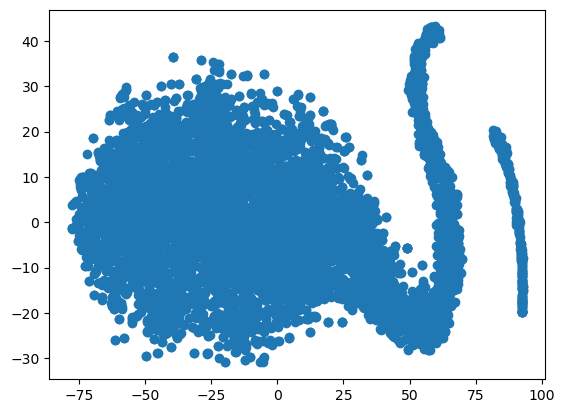

In [3]:
import numpy as np
import pandas as pd
embed_df = pd.read_csv('/home/lym/lab/project_work/GCN_Link_Prediction/data/word_embeddings_inference.csv')
# 假设 embeddings 是一个 numpy 数组，其中每一行代表一个节点的嵌入向量
embeddings = embed_df.to_numpy()

# 计算方差
variances = np.var(embeddings, axis=0)
print("方差:", variances)

# 计算相似度
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(embeddings)
print("相似度:", similarities)

# 可视化
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.show()


In [4]:
word_freq = {}
word_set = set()
f = open(r'/home/lym/lab/project_work/GCN_Link_Prediction/data/webofsci_train_allclean.txt', 'r')  
lines = f.readlines()
for doc_words in lines:
    words = doc_words.split()
    for word in words:
        word_set.add(word)
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1
vocab = list(word_set)
vocab_size = len(vocab)
print(vocab_size)

5563


In [6]:
import pandas as pd
source_data_comatrix_train = pd.read_csv(r'/home/lym/lab/project_work/GCN_Link_Prediction/data/source_data_comatrix_train.csv')
print(source_data_comatrix_train.shape[0])
source_data_tfidf_train = pd.read_csv(r'/home/lym/lab/project_work/GCN_Link_Prediction/data/source_data_tfidf_train.csv')
print(source_data_tfidf_train.shape[0])

5209558
313329


In [ ]:
# ? 求文档列表最小单词数、最大单词数及平均单词数
min_len = 10000  
aver_len = 0  
max_len = 0  
f = open(r'/home/lym/lab/project_work/GCN_Link_Prediction/data/webofsci_{}_allclean.txt'.format(data_type), 'r') 
lines = f.readlines()  
for line in lines:  
line = line.strip() 
temp = line.split() 
aver_len = aver_len + len(temp) 
if len(temp) < min_len:  
    min_len = len(temp) 
if len(temp) > max_len: 
    max_len = len(temp) 
f.close()
aver_len = 1.0 * aver_len / len(lines)  
print('min_len : ' + str(min_len))
print('max_len : ' + str(max_len))
print('average_len : ' + str(aver_len))

In [3]:
import yake

# 初始化参数
language = "en"
max_ngram_size = 1
deduplication_thresold = 0.9
deduplication_algo = 'seqm'
windowSize = 1
numOfKeywords = 20

# 存储所有关键词及其概率值
all_keywords = []

# 关键词的数量
num_keywords = 300

file_path = r'/home/lym/lab/project_work/project_versions/GCN_Link_Prediction_v3/test/text.txt'
with open(file_path, 'r') as file:
    lines = file.readlines()

for line in lines:
    text = line.strip()
    kw_extractor = yake.KeywordExtractor(lan=language, 
                                         n=max_ngram_size, 
                                         dedupLim=deduplication_thresold, 
                                         dedupFunc=deduplication_algo, 
                                         windowsSize=windowSize, 
                                         top=numOfKeywords)
    keywords = kw_extractor.extract_keywords(text)
    all_keywords.extend(keywords)

print(len(all_keywords))
# 使用字典来存储关键词及其最大概率值
keyword_dict = {}
for keyword, score in all_keywords:
    if keyword in keyword_dict:
        if score < keyword_dict[keyword]:  # 保留概率值较大的关键词
            keyword_dict[keyword] = score
    else:
        keyword_dict[keyword] = score

# 将字典转换回列表并排序
final_keywords = sorted(keyword_dict.items(), key=lambda x: x[1], reverse=True)
print(len(final_keywords))

# 根据概率值排序并取前300个关键词
top_keywords = final_keywords[:num_keywords]

output_file_path = r'/home/lym/lab/project_work/project_versions/GCN_Link_Prediction_v3/test/top_keywords_allclean.txt'
with open(output_file_path, 'w') as output_file:
    for keyword, score in top_keywords:
        print(f"Keyword: {keyword}, Score: {score}")
        output_file.write(f"{keyword}\t{score}\n")


200
133
Keyword: introduce, Score: 0.14309311733032487
Keyword: generative, Score: 0.14309311733032487
Keyword: surface, Score: 0.14309311733032487
Keyword: application, Score: 0.12087166686908857
Keyword: increase, Score: 0.12087166686908857
Keyword: demand, Score: 0.12087166686908857
Keyword: acceleration, Score: 0.12087166686908857
Keyword: compare, Score: 0.12087166686908857
Keyword: variant, Score: 0.11096530035436344
Keyword: deep, Score: 0.11096530035436344
Keyword: progress, Score: 0.11047399429666874
Keyword: system, Score: 0.11047399429666874
Keyword: learning, Score: 0.10263660867300752
Keyword: receive, Score: 0.09728094065105825
Keyword: field, Score: 0.09728094065105825
Keyword: excellent, Score: 0.09728094065105825
Keyword: performs, Score: 0.09728094065105825
Keyword: mesh, Score: 0.09694261754005654
Keyword: large, Score: 0.09694261754005654
Keyword: scale, Score: 0.09694261754005654
Keyword: improve, Score: 0.09694261754005654
Keyword: ability, Score: 0.09694261754005

In [9]:
# 文件路径
train_file_path = r'/home/lym/lab/project_work/project_versions/GCN_Link_Prediction_v3/data/webofsci_test_clean.txt'
vocab_file_path = r'/home/lym/lab/project_work/project_versions/GCN_Link_Prediction_v3/data/webofsci_vocabulary_test.txt'

# 读取训练文件中的所有文本行
with open(train_file_path, 'r') as train_file:
    train_lines = train_file.readlines()

# 读取词汇表中的所有词汇
with open(vocab_file_path, 'r') as vocab_file:
    vocab_words = [line.strip() for line in vocab_file]

# 将所有文本行合并成一个大字符串，并转换为小写
train_text = ' '.join(line.strip().lower() for line in train_lines)

# 检查词汇表中的词是否出现在训练文本中
words_in_train = {word: (word in train_text) for word in vocab_words}

count = 0

# 打印结果
for word, is_in_train in words_in_train.items():
    print(f"Word: {word}, In Train: {is_in_train}")
    if not is_in_train:
        count = count +1
print(count)

Word: fails, In Train: True
Word: vis-nir, In Train: True
Word: problematic, In Train: True
Word: peaks, In Train: True
Word: runs, In Train: True
Word: intuitively, In Train: True
Word: variously, In Train: True
Word: inappropriate, In Train: True
Word: blocking, In Train: True
Word: spite, In Train: True
Word: malignancy, In Train: True
Word: documented, In Train: True
Word: interacts, In Train: True
Word: mikae, In Train: True
Word: eastern, In Train: True
Word: bulbosa, In Train: True
Word: colomatta, In Train: True
Word: lutea, In Train: True
Word: deliver, In Train: True
Word: scripts, In Train: True
Word: correctness, In Train: True
Word: connecting, In Train: True
Word: cocatalyst-free, In Train: True
Word: concentrated, In Train: True
Word: pharmacology, In Train: True
Word: break, In Train: True
Word: guide, In Train: True
Word: few-layer, In Train: True
Word: roofs, In Train: True
Word: motivates, In Train: True
Word: modulating, In Train: True
Word: screened, In Train: True

In [4]:
import pandas as pd
df_comatrix_normalized = pd.read_csv(r'/home/lym/lab/project_work/project_versions/GCN_Link_Prediction_v3/data/2_comatrix_normalized_train.csv', index_col=0)
pd_data = pd.read_csv(r'/home/lym/lab/project_work/project_versions/GCN_Link_Prediction_v3/data/webofsci_tf-idf_features_train.csv', index_col=0)
print(df_comatrix_normalized.shape)
print(pd_data.shape)

(1000, 1000)
(3818, 1000)


In [8]:
import scipy.sparse as sp  
from utils import find_new_words
from sklearn.feature_extraction.text import TfidfVectorizer  
import numpy as np
import pandas as pd
from scipy.sparse import lil_matrix
from collections import Counter
import yake
data_type = "train"
if data_type == "train":
    df_comatrix = pd.read_csv(r'/home/lym/lab/project_work/project_versions/GCN_Link_Prediction_v3/data/2_comatrix_train.csv', index_col=0)
    # * 对词共现关系矩阵进行双向归一化并保存
    # ! 注意：如果某些点无任何连接，那么它的度就为0，导致度矩阵存在零值，影响计算，可以将零值转为一个非常小的值
    comatrix = sp.csr_matrix(df_comatrix.values)  
    degrees = np.array(comatrix.sum(1)).flatten()  
    np.savetxt(r'/home/lym/lab/project_work/project_versions/GCN_Link_Prediction_v3/data/2_degrees_{}.csv'.format(data_type), degrees, delimiter=',')

In [5]:
import scipy.sparse as sp  
from utils import find_new_words
from sklearn.feature_extraction.text import TfidfVectorizer  
import numpy as np
import pandas as pd
from scipy.sparse import lil_matrix
from collections import Counter
import re
import yake

df = pd.read_csv(r'/home/lym/lab/project_work/project_versions/GCN_Link_Prediction_v3/data/1_webofsci_train_allclean.txt', header=None, sep = '\0')
vocab = pd.read_csv(r'/home/lym/lab/project_work/project_versions/GCN_Link_Prediction_v3/data/2_webofsci_vocabulary_train.txt', header=None)
vocab = vocab[0].tolist()
tf_idf_vectorizer = TfidfVectorizer(vocabulary = vocab, token_pattern=r'(?u)\b\w[\w-]*\b')

tf_idf = tf_idf_vectorizer.fit_transform(df[0])

matrix_keywords_words = tf_idf.toarray()

columns = vocab

pd_data = pd.DataFrame(matrix_keywords_words, columns = columns)

print(pd_data.shape)

zero_columns = pd_data.columns[(pd_data == 0).all()]
print("所有元素为零的列：")
print(zero_columns)

(3818, 500)
所有元素为零的列：
Index(['high-throughput', 'vis-nir', 'drug-drug', 'network-based',
       'three-dimensional', 'low-pass', 'water-splitting', 'cocatalyst-free',
       'pixel-wise', 'labor-intensive', 'few-layer', 'weak-generalization',
       'high-order', 'single-crystal', 'nitrogen-rich', 'pei-gcn', 'sub-tasks',
       'real-world', 'dempster-shafer', 'time-consuming', 'tev-pev',
       'oval-shaped', 'self-healing', 'dual-stimulus', 'ogbn-arxiv',
       'ground-truth', 'cutting-thin', 'u-shaped', 'f-score'],
      dtype='object')
